<a href="https://colab.research.google.com/github/Drisnor/IA/blob/master/M2_RFA_CCTP_GIMENEZ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Contrôle de TP M2 IARF-Rodeco

**Auteurs :** Benjamin Chamand - Thomas Pellegrini

Le but de cette séance est d'évaluer vos compétences sur un projet d'apprentissage profond en utilisant un nouveau corpus.

Contrairement aux séances précédentes, nous allons travailler cette fois-ci sur un corpus audio contenant 10 classes (craquemens de feu, tic-tac d'une horloge, le bruit d'un coq, etc...).

Les fichiers audio sont convertis en spectrogramme, une représentation temps/fréquence du signal qui peut être vue comme une image.

**La méthodologie reste la même et ne change absolument pas par rapport aux séances précédentes ! Toutes les méthodes vues durant les séances précédentes peuvent donc être réapliquées ici.**

## Gestion des pré-requis avant de commencer le contrôle

__Afin de ne pas perdre du temps sur les exécutions de chaque cellule du notebook, vous pouvez tout exécuter en allant dans le menu *Exécution* puis *Tout exécuter*__

### Importation des bibliothèques

Premièrement, faisons les importations nécessaires

In [ ]:
import os
import random
import requests
import zipfile

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils import np_utils, normalize
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.preprocessing import StandardScaler

import numpy as np
import matplotlib.pyplot as plt

Installation de la bibliothèque **librosa** qui va se charger d'ouvrir les fichiers audio et d'en extraire le spectrogramme qui sera traité ensuite comme une image dans la suite.

In [ ]:
!pip install librosa
import librosa
import librosa.display

Vérifier bien que Keras utilise le GPU pour les calculs.
Si ce n'est pas le cas, il faut aller dans Exéction > Modifier le type d'exécution > Accélérateur Matériel > GPU

In [ ]:
if K.backend() == "tensorflow":
    from tensorflow.python.client import device_lib
    print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15051603982601106533
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 14667980893574120177
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 1796476190542541145
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11146722048
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14235324698553413346
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


### Fixer la seed

On fixe la seed afin de retrouver les mêmes résultats à chaque lancement du programme.

In [ ]:
from numpy.random import seed
seed(123) # On peut utiliser n'importe quelle nombre

import tensorflow
tensorflow.random.set_seed(1234)

### Chargement du corpus

Le corpus est constitué de 10 concepts audio qui sont :
* **tronçonneuse** *(chainsaw)*
* **tic-tac d'une horloge** *(clock_tick)*
* **craquement de feu** *(crackling_fire)*
* **pleurs de bébé** *(crying_baby)*
* **chien** *(dog)*
* **hélicoptère** *(helicopter)*
* **pluie** *(rain)*
* **coq** *(rooster)*
* **bruit des vagues** *(sea_waves)*
* **éternuement** *(sneezing)*

Nous voulons classifier les différents fichiers audio suivant les 10 classes.

#### Téléchargement du corpus

On récupère tout d'abord le corpus

In [ ]:
!wget -O dataset.zip https://www.irit.fr/~Thomas.Pellegrini/ens/M2RFA/dataset.zip
!unzip -qq dataset.zip -d data/
!rm dataset.zip

--2020-10-09 12:56:01--  https://www.irit.fr/~Thomas.Pellegrini/ens/M2RFA/dataset.zip
Resolving www.irit.fr (www.irit.fr)... 141.115.28.2
Connecting to www.irit.fr (www.irit.fr)|141.115.28.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 128685900 (123M) [application/zip]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>] 122.72M  3.27MB/s    in 31s     

2020-10-09 12:56:32 (3.95 MB/s) - ‘dataset.zip’ saved [128685900/128685900]

replace data/test/chainsaw/1-64398-B-41.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


La base de données téléchargée est stockée dans :

```
./data
```
Vous pouvez visualiser l'arborescence des données dans la colonne de gauche sous l'onglet *Fichiers* et en cliquant sur le bouton *actualiser* si les données n'apparaissent pas.

In [ ]:
base_dir = './data'

#### Chargement du corpus dans la mémoire

La fonction **load_dataset** permet de charger les données d'apprentissage ou les données de test en mémoire.

**Attention :** le chargement est un peu long (environ 2min)

In [ ]:
idx_to_classes = ['chainsaw', 'clock_tick', 'crackling_fire', 'crying_baby',
                  'dog', 'helicopter', 'rain', 'rooster', 'sea_waves',
                  'sneezing']


def load_dataset(path):
    spec = []
    labels = []
    for idx, label in enumerate(idx_to_classes):
        with os.scandir(os.path.join(path, label)) as it:
            for entry in it:
                if (not entry.name.startswith('.')
                        and entry.name.endswith('.wav')):
                    # load audio
                    y, sr = librosa.load(entry.path)
                    # convert audio to melspectrogram
                    spec.append(librosa.feature.melspectrogram(y, sr,
                                                              n_fft=2048,
                                                              hop_length=512,
                                                              power=2.0))
                    # add associated label
                    labels.append(idx)

    # mélange les données 
    #combined = list(zip(spec, labels))
    #random.shuffle(combined)
    #spec, labels = zip(*combined)
    return np.array(spec), np.array(labels)

In [ ]:
# Le chargement des données est assez long : un peu moins de 2min
%%time

print("Chargement du corpus d'apprentissage")
train_dir = os.path.join(base_dir, 'train')
x_train, y_train = load_dataset(train_dir)

print("Chargement du corpus de test")
test_dir = os.path.join(base_dir, 'test')
x_test, y_test = load_dataset(test_dir)

Chargement du corpus d'apprentissage
Chargement du corpus de test
CPU times: user 1min 59s, sys: 24.6 s, total: 2min 23s
Wall time: 3min 19s


#### Taille du corpus

Affichage de la taille du corpus. Pour cela, il suffit de compter le nombre d'images qu'il y a dans les dossiers correspondant à chaque label aussi bien dans le corpus d'apprentissage que dans le corpus de test.

In [ ]:
# Affichage du nombre d'exemples totales dans le corpus
print('Taille du corpus total')
print('\t• train :', len(x_train), 'exemples')
print('\t• test :', len(x_test), 'exemples')

# Affichage de la taille des images et des labels dans le corpus 
print('\nTaille des données d\'apprentissage')
print('\t• X_train (images) :', x_train.shape)
print('\t• y_train (labels) :', y_train.shape)

print('\nTaille des données de test')
print('\t• X_test (images) :', x_test.shape)
print('\t• y_test (labels) :', y_test.shape)

Taille du corpus total
	• train : 320 exemples
	• test : 80 exemples

Taille des données d'apprentissage
	• X_train (images) : (320, 128, 216)
	• y_train (labels) : (320,)

Taille des données de test
	• X_test (images) : (80, 128, 216)
	• y_test (labels) : (80,)


**Correspondance ID du label / signification**

Définition de la liste *idx_to_classes* permettant à partir de la valeur du label de retrouver sa signification

In [ ]:
idx_to_classes = ['chainsaw', 'clock_tick', 'crackling_fire', 'crying_baby',
                  'dog', 'helicopter', 'rain', 'rooster', 'sea_waves',
                  'sneezing']

# du corpus d'apprentissage
print("Affichage de la correspondance des labels :")
for i in range(10):
    n = random.randint(0, len(y_train)-1)
    print('• y_train[' + str(n) + '] =', y_train[n], '->', idx_to_classes[y_train[n]])

Affichage de la correspondance des labels :
• y_train[219] = 6 -> rain
• y_train[54] = 1 -> clock_tick
• y_train[72] = 2 -> crackling_fire
• y_train[10] = 0 -> chainsaw
• y_train[119] = 3 -> crying_baby
• y_train[55] = 1 -> clock_tick
• y_train[245] = 7 -> rooster
• y_train[245] = 7 -> rooster
• y_train[99] = 3 -> crying_baby
• y_train[147] = 4 -> dog


**Affichage des images**

On affiche maintenant quelques images issues du corpus avec le label associé

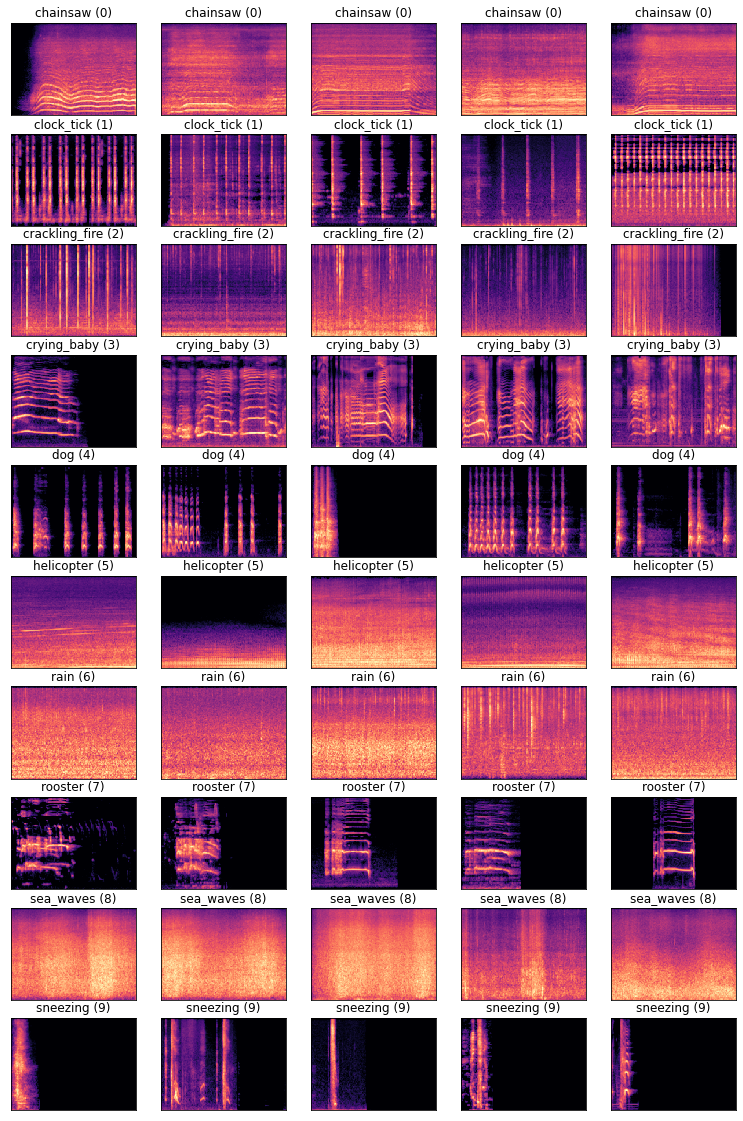

In [ ]:
plt.figure(figsize=(13,20))

n = 0
for i in range(10):
    for j in range(5):
        # récupération d'une image et de son label associé
        img, target = x_train[n+j], y_train[n+j]
        # affiche du spectrogramme
        plt.subplot(10,5,i*5+j+1)
        img = librosa.power_to_db(img)
        librosa.display.specshow(img, cmap='magma')
        # ajout d'un titre à l'image
        plt.title('{} ({})'.format(idx_to_classes[target], target))
        #plt.colorbar(format='%+2.0f dB')
    n += 32
              
plt.show()

## Classification de fichiers audio en utilisant de l'apprentissage profond

Maintenant c'est à vous de jouer, vous devez implémenter différentes architectures de réseaux de neurones à partir de vos connaissances et des modèles que vous avez vus dans les séances précédentes.

Pour cela, vous devriez :

* faire attention au format des données en entrée (reshape des images, transformer un vecteur en one-hot encoding, etc.) ;
* déclarer l'architecture ;
* compiler le modèle ;
* lancer l'apprentissage ;
* évaluer le modèle ;
* lancer la prédiction sur quelques images de tests.

Pour l'évalutation du modèle, nous utiliserons nos données de tests ce qui n'est normalement pas rigoureux.

In [ ]:
# Conversion des données en type float32:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
nb_classes = 10
"""
# définition de la standardisation
def standardisation(X_train, X_test):
    mean = np.mean(X_train, axis=0)
    var = np.var(X_train, axis=0)
    return ((X_train - mean) / var), ((X_test - mean) / var)
"""
# définition du rééchelonnage
def reechelonnage(X_train, X_test):
    X_train /= X_train.max(axis=0)
    X_test /= X_test.max(axis=0)
    return X_train, X_test

# one-hot encoding
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

# affichage de l'encodage des labels sur les 10 premières données
# du corpus d'apprentissage
print("Affichage de l'encodage des labels :")
for i in range(10):
    print('• y_train[' + str(i) + '] =', y_train[i], '->', Y_train[i])

#redimension des données d'entrée
print(x_train.shape)
input_size_img = x_train.shape[1] * x_train.shape[2]
X_train = x_train.reshape((-1, input_size_img))
X_test = x_test.reshape((-1, input_size_img))

# Standardisation des donneés
#X_train, X_test = standardisation(X_train, X_test)
X_train, X_test = reechelonnage(X_train, X_test)
#X_train, X_test = normalize(X_train, axis=1), normalize(X_test, axis=1)  # avec Keras

print('\nTaille des données :')
print('\t• X_train :', X_train.shape)
print('\t• X_test :', X_test.shape)

#definition du modele MLP
model = Sequential()

Affichage de l'encodage des labels :
• y_train[0] = 0 -> [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
• y_train[1] = 0 -> [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
• y_train[2] = 0 -> [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
• y_train[3] = 0 -> [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
• y_train[4] = 0 -> [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
• y_train[5] = 0 -> [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
• y_train[6] = 0 -> [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
• y_train[7] = 0 -> [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
• y_train[8] = 0 -> [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
• y_train[9] = 0 -> [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(320, 128, 216)

Taille des données :
	• X_train : (320, 27648)
	• X_test : (80, 27648)


### Réseau MLP

Dans cette section, vous allez devoir implémenter un réseau dense à 1 ou plusieurs couches cachées

In [ ]:
#definition du modele MLP à une couche
model = Sequential()

model.add(Dense(50, activation="relu", name="layer1", input_shape=(input_size_img,)))
# Ajouter maintenant la couche de sortie avec le bon nombre de neurones et la bonne fonction d'activation :
model.add(Dense(10, activation="softmax", name="output"))

#optimizer = keras.optimizers.RMSprop(lr=0.005, decay=1e-6)
# keras.optimizers.Adam(lr=0.01, decay=1e-6)
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

history = model.fit(X_train, 
                    Y_train,
                    epochs=15)

scores = model.evaluate(X_test, Y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, 50)                1382450   
_________________________________________________________________
output (Dense)               (None, 10)                510       
Total params: 1,382,960
Trainable params: 1,382,960
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
10/10 [==============================] - 0s 5ms/step - loss: 2.2221 - accuracy: 0.2000
Epoch 2/15
10/10 [==============================] - 0s 5ms/step - loss: 1.9688 - accuracy: 0.4344
Epoch 3/15
10/10 [==============================] - 0s 5ms/step - loss: 1.7269 - accuracy: 0.5594
Epoch 4/15
10/10 [==============================] - 0s 4ms/step - loss: 1.5193 - accuracy: 0.6406
Epoch 5/15
10/10 [==============================] - 0s 4ms/step - loss: 1.3286 - accuracy: 0.7156
Epoch 6/15
10/10

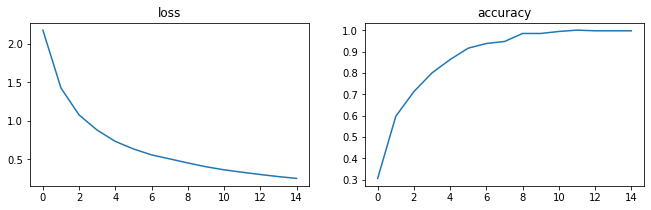

In [ ]:
plt.figure(figsize=(11,3))

# affichage de la valeur de la fonction de perte
plt.subplot(1,2,1)
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

# affichage de la précision de notre réseau sur les données d'apprentissage
plt.subplot(1,2,2)
plt.plot(history.epoch,history.history['accuracy'])
plt.title('accuracy');

### Réseau convolutif

Maintenant, vous allez implémenter un réseau convolutif.

In [ ]:
im_height, im_width = 128, 216
n_channels = 1
X_train = x_train.reshape(-1, im_height, im_width, n_channels)
X_test = x_test.reshape(-1, im_height, im_width, n_channels)

# défintion du modèle

model = Sequential()

model.add(Conv2D(16, 3, input_shape=(im_height, im_width, n_channels)))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.summary()

model.compile(optimizer='nadam', loss='categorical_crossentropy',  metrics=['accuracy'])
"""
model = Sequential()
model.add(Conv2D(64, 3, input_shape=(im_height,im_width,n_channels)))
model.add(Activation('relu'))
model.add(Conv2D(128, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# MLP
model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))

# Sortie
model.add(Dense(10, activation='softmax'))
model.compile(optimizer=optimizer,loss="categorical_crossentropy",metrics=["accuracy"])
"""

# Entrainement
history = model.fit(X_train, 
                    Y_train,
                    epochs=10)

scores = model.evaluate(X_test, Y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 214, 16)      160       
_________________________________________________________________
activation_1 (Activation)    (None, 126, 214, 16)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 107, 16)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 107856)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                6902848   
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 6,903,658
Trainable params: 6,903,658
Non-trainable params: 0
____________________________________________